# <b>Airbnb Provider Segmentation</b>

https://medium.com/airbnb-engineering/from-data-to-insights-segmenting-airbnbs-supply-c88aa2bb9399

At Airbnb, our supply comes from hosts who decide to list their spaces on our platform. Unlike traditional hotels, these spaces are not all interchangeable units in a building that are available to book year-round. Our hosts are people, with different earnings objectives and schedule constraints — leading to different <b>levels of availability</b> to host. <b>Understanding these differences is a key input into how we develop our products, campaigns, and operations.</b>

Over the years, we’ve created various ways to <b>measure host availability</b>, developing “features” that capture different aspects of how and when listings are available. However, these features provide an incomplete picture when viewed in isolation. For example, a ~30% availability rate could indicate two very different scenarios: a host who only accepts bookings on weekends, or a host whose listing is only available during a specific season, such as summer.

This is where segmentation comes in.

<h4>❛❛By combining multiple features, segmentation allows us to create discrete categories that represent the different availability patterns of hosts.❜❜</h4>

But traditional segmentation methodologies, such as “RFM” (Recency, Frequency, Monetary), are focused on customer value rather than calendar dynamics, and are often limited to one-off analyses on small datasets. In contrast, we need <b>an approach that can handle calendar data and daily inference for millions of listings.</b>

To address the above challenges, this blog post explores how Airbnb used segmentation to better understand host behavior at scale. By enriching availability data with novel features and applying machine learning techniques, we developed a practical and scalable approach to segment availability for millions of listings daily.

## <b>Example: Distinguishing Hosts with Similar Profiles</b>

Consider Alice and Max, two hosts with identical 2-bedroom apartments on Airbnb. However, Alice only lists her property in the summer, while Max has it available year-round — reflecting two distinct hosting styles.

Alice’s seasonal availability suggests that she might live in the property most of the time, only renting it out during the summer months. Airbnb can support her with seasonal pricing tips, onboarding guides for occasional hosts, and settings suggestions.

Conversely, Max’s full-time availability indicates a more professional hosting style, possibly his primary income source. Airbnb can provide him with advanced booking analytics, tools for managing multiple reservations, and guidance on earnings and tax implications.

<div class="alert alert-block alert-success">
<b>Syntax:</b> DataFrame.pivot_table(values=None, index=None, columns=None, aggfunc=’mean’, fill_value=None, margins=False, dropna=True)
</div>

In [11]:
import pandas as pd

# Original data
d = {
    "Host": ["Alice", "Max"],
    "Location": ["Paris", "Paris"],
    "Listing size": ["2-bedroom", "2-bedroom"],
    "Host tenure": ["8+ years", "8+ years"],
    "Host status": ["Superhost", "Superhost"],
    "Listing availability": ["Seasonal", "Full Time"],
    "Archetype": ["Only available during Summer", "Always available"]
}

data = pd.DataFrame(data=d)

# Melt the data to long format
melted = data.melt(id_vars="Host", var_name="Attribute", value_name="Value")

# Pivot so each Host is a column
table = melted.pivot(index="Attribute", columns="Host", values="Value")

print(table)


Host                                         Alice               Max
Attribute                                                           
Archetype             Only available during Summer  Always available
Host status                              Superhost         Superhost
Host tenure                               8+ years          8+ years
Listing availability                      Seasonal         Full Time
Listing size                             2-bedroom         2-bedroom
Location                                     Paris             Paris


<b>How can we create a dataset that captures these crucial differences in hosting behavior?</b>

## <b>Dataset</b>

### <b>Availability Rate</b>

A first step is to capture the host’s “intention to be available” on a specific night. Availability can be both analyzed from a backward-looking (in the past) or forward-looking (in the future) perspective. For simplicity, this post focuses on backward-looking availability, as it reflects the final state of a calendar after all changes in inventory, bookings and cancellations have occurred. Forward-looking availability is not as straightforward because changes can still happen between the analysis date and the future dates being analyzed.

We consider both:
<ul>
    <li><b>Nights Vacant</b>: nights when the listing was listed as available for booking on Airbnb, and remained vacant.</li>
    <li><b>Nights Booked</b>: nights when the listing was listed as available for booking on Airbnb, and was later booked on Airbnb.</li>
</ul>

Consequently, we can calculate the corresponding Nights Intended to be Available, or Nights Available, for the 365-day look-back period as the sum of Nights Vacant and Nights Booked. We then divide it by 365, to obtain the corresponding <b>Availability Rate.</b>

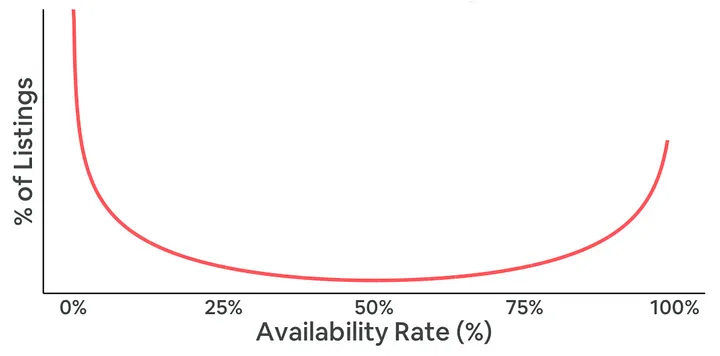

Distribution of Listings by Availability Rate in the Previous Year (Illustrative)<br>

From this distribution we observe:
<ul>
    <li>A considerable proportion of listings has little-to-no availability (~0% availability rate).</li>
    <li>Conversely, a significant proportion of listings has near full availability (~100% availability rate).</li>
    <li>Between these extremes, a significant set of listings emerges without strong breakpoints.</li>
</ul>

How can we further differentiate these listings that fall in the middle range?

### <b>Streakiness</b>

For listings that are not at either end of the spectrum, availability rate on its own is insufficient for capturing the nuances of how a listing is made available throughout the month. Consider listings A and B, which both have a 50% availability rate in a given month.

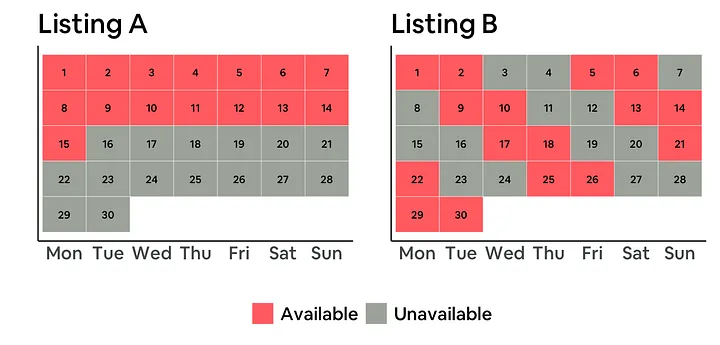

Two Listings with Similar Availability Rates but Distinct Calendar Patterns

Although these listings have distinct availability patterns, they both have the <b>same availability rate (50%)!</b>

Listing A’s concentrated, block-like availability could lend itself to recommendations for weekly stay discounts, or advice for hosts who are away for a longer stretch — guidance which may not be suitable for Listing B.

To capture this distinction, we introduce “Streakiness”. In the example above, Listing A had 1 long streak of availability which was interrupted on night 16, while Listing B had 8 short streaks of availability, each lasting 2 nights before a 2-night break.

We define a streak as a consecutive sequence of availability with a minimum of 2 consecutive nights, followed by a subsequent period of at least 2 consecutive nights of unavailability, as described in the diagram below. Note that we initially considered using a single night of availability/unavailability as a threshold but found it to be a less reliable signal of the consistency that streakiness aims to measure.

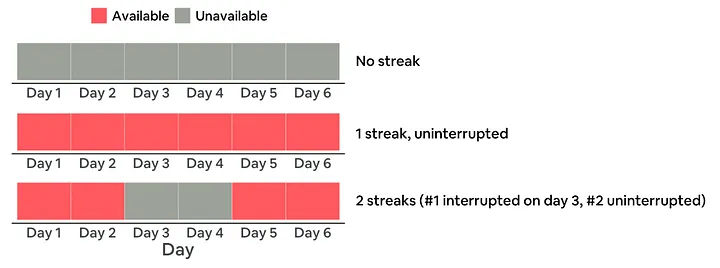

This leads us to the corresponding Streakiness feature, computed as the ratio of Streaks divided by the number of Nights Available (computed in the previous section). At this point, we now have two relatively orthogonal features for our analysis: availability rate and streakiness.

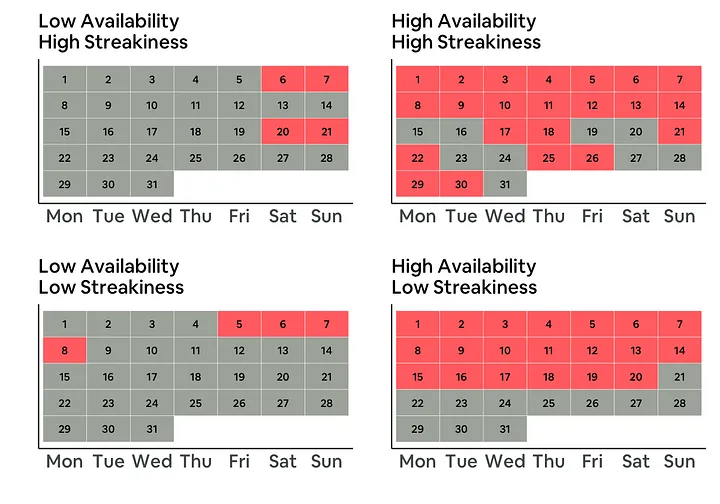

Combining Availability + Streakiness

### <b>Seasonality</b>
We found that while availability and streakiness provide a solid basis for measuring volume and consistency, they don’t capture a calendar’s “compactness” — in other words, its seasonality. As an example, consider Listings C and D, which both have around 15% availability and 14 streaks:
<ul>
    <li>Listing C concentrates its availability within a narrower block of time (summer season) — see first calendar below.</li>
    <li>Listing D distributes its availability more evenly across multiple quarters — see second calendar below.</li>
</ul>

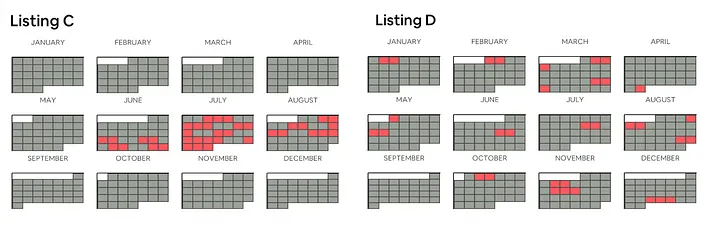

Seasonality plays a crucial role in Airbnb’s business, as guest demand and host availability fluctuate with changes in seasonal appeal, holidays, and local events. Given this, we propose to create a <b>Quarters with at Least One Night of Availability feature.</b>

Additionally, we create a <b>Maximum Consecutive Months feature</b> which captures streakiness at a yearly scale, highlighting the longest continuous period a listing is available. Together, these features give clearer insight into seasonal patterns.

### <b>Final dataset</b>

The final feature set includes all listings that were listed on the platform as of a broad set of dates. For each listing, we calculate the features we’ve designed in the previous sections. Then, we take a large, random sample across these dates. Finally, we scale the numerical features to ensure they are on a comparable scale.

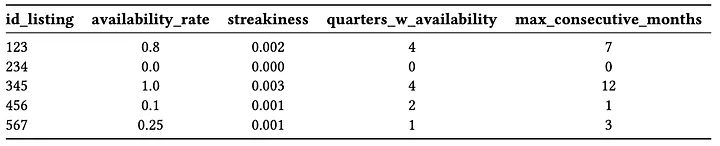

## <b>Segmentation Model</b>
We can now apply a <b><u>K-means clustering algorithm</u></b> to identify segments, testing models with K values from 2 to 10. Using the <b><u>elbow plot</u></b> to find the optimal number of clusters, we select 8 clusters as the best representation of our data.

We now have our clusters, but they don’t have names yet. Our cluster naming process involves several steps:
<ul>
    <li>Checking the distribution of each feature by cluster to identify strong differences (e.g., “cluster 1 has the highest availability rate”)</li>
    <li>Randomly sampling listings from each cluster and visualizing their calendars</li>
    <li>Iterating on naming with a cross-functional internal working group</li>
</ul>

The output of this process is summarized in the table below, while the following diagram displays a “typical” calendar for each cluster.

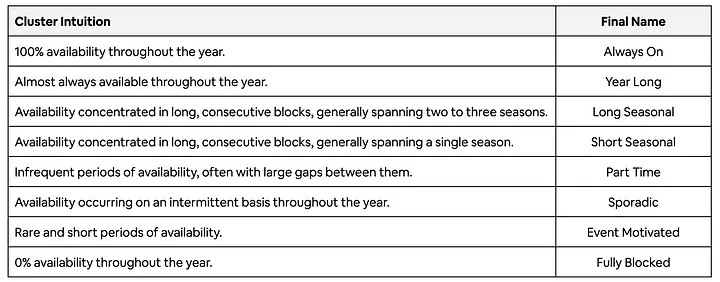

From Cluster Intuition to Cluster Name

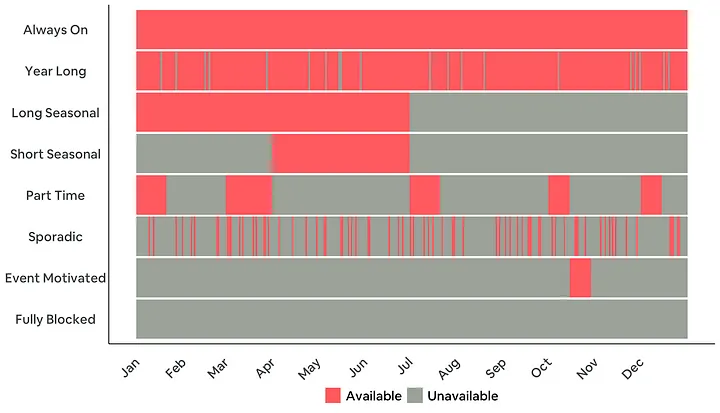

Examples of Calendars by Cluster

### <b>Segment Validation</b>
Since we are measuring a latent attribute — underlying host behavior patterns that don’t have “ground truth” labels — there is no perfectly accurate way to validate our segmentation. However, we can use various methodologies to ensure that it “makes sense” from a business perspective, and reliably reflects real-life host behaviors.

We do so in three steps:
<ul>
    <li>A/B Testing</li>
    <li>Correlates of Availability Segments</li>
    <li>User Experience (UX) Research</li>
</ul>

#### <b>A/B Testing</b>

In an A/B test, we assessed how the different segments previously used a feature that encouraged hosts to complete “recommended actions” (e.g., letting guests book their home last-minute) so they may earn a monetary incentive.

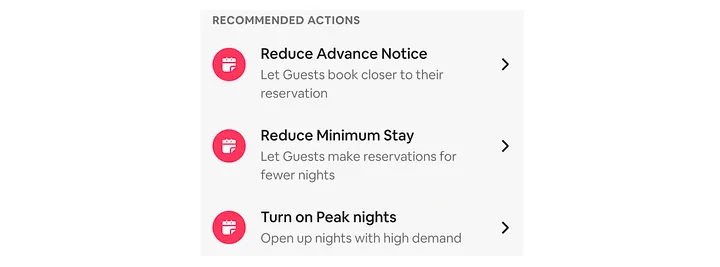

We show the use of the feature by each segment below. These results align with our intuition: hosts who use Airbnb for specific occasions or rarely may not be interested in following recommendations, even when incentivized. Similarly, “Always On” hosts, who are already highly engaged and proactive in managing their listings, might prefer to rely on their own strategies rather than follow Airbnb’s suggestions. Hosts who fall somewhere in between, with moderate levels of engagement, may be the ideal target for incentives, as they are likely open to adjustments that could boost their performance.

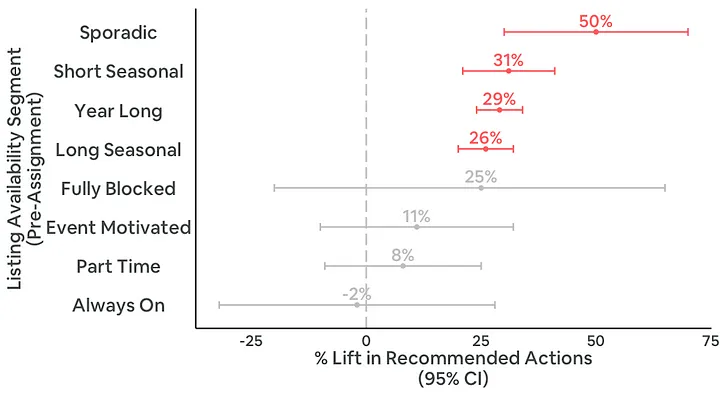

Example of Heterogeneous Treatment Effects by Availability Segment
(“CI” = Confidence Interval)

#### <b>Correlates of Availability Segments</b>
We also validate our clusters by checking correlations with known attributes. For instance, we confirm that “Always On” listings are likely more managed by professionals, or that “Short Seasonal” listings are likely more common in ski or beach destinations.

Furthermore, we know it is common to observe an increase in the number of listings around big events. As expected, we observe a rise in “Event Motivated” listings leading up to and during major events periods, reflecting hosts’ responsiveness to increased demand.

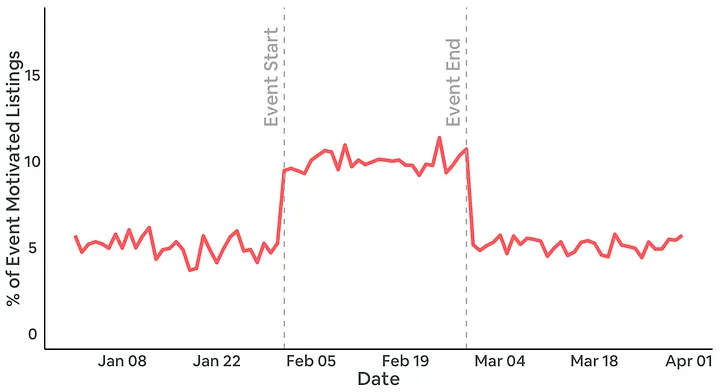

#### <b>UX Research</b>

Finally, we know the UX Research team conducts host surveys to create qualitative personas, which we compare against our clusters to ensure they align with real-world behavior. For instance, we verify if segments with high weekend availability match hosts who self-report preferring weekend rentals.

### <b>Scaling and Productionization</b>

Now, we need to scale this segmentation to all our listings.

To achieve this, we use a <b><u>decision tree algorithm.</u></b> We train a model using our 4 features, with cluster labels from our K-means model as outputs. We also perform a train-test split to make sure the model accurately predicts each cluster.

This new model provides a simple, interpretable set of if-else rules to classify listings into clusters. <b>Using the decision tree structure, we translate the model’s logic into a SQL query by converting the decision tree’s “IF” conditions into “CASE WHEN” statements.</b> This integration enables the model to be propagated in our data warehouse.

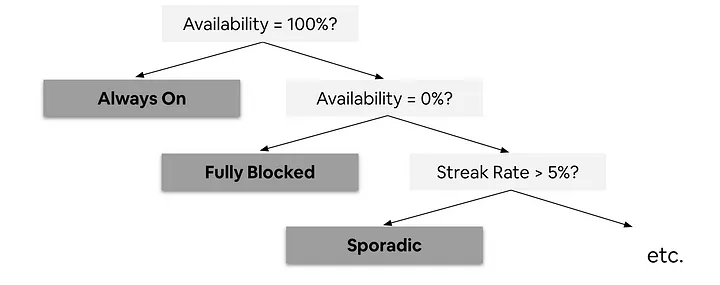

### <b>Applications at Airbnb and Beyond</b>
At Airbnb, various teams leverage these segments: product teams to inform strategy and analyze heterogeneous treatment effects in A/B tests, marketing teams for targeted messaging, and UX research teams for insights into hosts’ motivations.

For instance, we revealed an opportunity to boost <b><u>Instant Book</u></b> adoption among “Event Motivated” hosts, who may occasionally list their primary residence and prefer manual guest screening. Adding an option for hosts to only accept guests with a certain rating may make Instant Book more appealing to them, offering a balance between host control and booking efficiency.

Initially designed for listing availability data, this segmentation methodology has also been adapted to host activity data. We developed a second segmentation focused on days with “host engagement” (e.g., adjusting prices, updating policies, revising listing descriptions) to differentiate occasional “Settings Tinkerers” from frequent “Settings Optimizers.”

<b>This approach can also be adapted to other industries where understanding temporal engagement is essential,</b> for instance, to distinguish:
<ul>
    <li>Social Media: casual lurkers vs. active content creators</li>
    <li>Ridesharing: occasional drivers during peak demand vs. full-time drivers</li>
    <li>Streaming Services: nighttime streamers vs. continuous streamers</li>
    <li>E-commerce: sales/holidays enthusiasts vs. year-round shoppers</li>

#### <b>Acknowledgments</b>
This blog post was a collaborative effort, with significant contributions from Tim Abraham, the main co-author. We’d also like to acknowledge the invaluable support of team members from multiple organizations, including (but not limited to) Regina Wu, Maggie Jarley, and Peter Coles.